In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
csvpath = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/atlasV8/csv'

In [3]:
df_midbrain_distance = pd.read_csv(os.path.join(csvpath, 'using_midbrain_distance.csv'))
df_midbrain_allen = pd.read_csv(os.path.join(csvpath, 'using_midbrain_allen.csv'))
df_midbrain_atlas = pd.read_csv(os.path.join(csvpath, 'using_midbrain_atlas.csv'))

In [ ]:
df_all_distance = pd.read_csv(os.path.join(csvpath, 'using_all_distance.csv'))
df_all_allen = pd.read_csv(os.path.join(csvpath, 'using_all_allen.csv'))
df_all_atlas = pd.read_csv(os.path.join(csvpath, 'using_all_atlas.csv'))

In [ ]:
df_brainstem_distance = pd.read_csv(os.path.join(csvpath, 'using_brainstem_distance.csv'))
df_brainstem_allen = pd.read_csv(os.path.join(csvpath, 'using_brainstem_allen.csv'))
df_brainstem_atlas = pd.read_csv(os.path.join(csvpath, 'using_brainstem_atlas.csv'))

In [ ]:
midbrain_distances = df_midbrain_distance.distance
all_distances = df_all_distance.distance
brainstem_distances = df_brainstem_distance.distance
fig, ax = plt.subplots(figsize=(8, 6))
columns = [midbrain_distances, all_distances, brainstem_distances]
ax.boxplot(columns, patch_artist=True)
ax.set_title("Distances between the DK atlas and the Allen (um)")
title1 = f"Using mid-brain\nn={len(midbrain_distances)}, min={round(min(midbrain_distances))}"
title1 += f"\nmax={round(max(midbrain_distances))}, mean={round(np.mean(midbrain_distances))}"
title2 = f"Using all structures\nn={len(all_distances)}, min={round(min(all_distances))}"
title2 += f"\nmax={round(max(all_distances))}, mean={round(np.mean(all_distances))}"
title3 = f"Using brainstem structures\nn={len(brainstem_distances)}, min={round(min(brainstem_distances))}"
title3 += f"\nmax={round(max(brainstem_distances))}, mean={round(np.mean(brainstem_distances))}"
plt.xticks([1,2,3], [title1, title2, title3])
plt.show()

In [ ]:
len(all_distances), min(all_distances), max(all_distances), np.mean(all_distances)

In [ ]:
for i, row in df_midbrain_distance.iterrows():
    print(f'{row[0]} distance={round(row[1],2)}')

In [ ]:
for i, row in df_brainstem_distance.iterrows():
    print(f'<tr><td>{row[0]}</td> <td>{round(row[1],2)}</td></tr>')

In [4]:
xmin = 8000
xmax = 13000
ymin = 2000
ymax = 6000
zmin = 0
zmax = 25*456

In [6]:
df_midbrain_atlas.head(20)

,Structure,xyz,S,area,X,Y,Z
0,3N_L,[9060.53672721 3933.42740169 5551.67656027],Left,midbrain,9060.536727,3933.427402,5551.676560
1,3N_R,[9109.79997904 3972.9776072 5858.96157538],Right,midbrain,9109.799979,3972.977607,5858.961575
2,4N_L,[9621.21433275 3894.08310039 5363.8536328 ],Left,midbrain,9621.214333,3894.083100,5363.853633
3,4N_R,[9611.04033914 3950.10999013 5939.75640937],Right,midbrain,9611.040339,3950.109990,5939.756409
4,5N_L,[10388.74066332 5052.91138367 4022.92305857],Left,brainstem,10388.740663,5052.911384,4022.923059
5,5N_R,[10370.83739148 4994.85377187 7177.86185275],Right,brainstem,10370.837391,4994.853772,7177.861853
6,6N_L,[11072.96059377 5058.90401226 5128.22905839],Left,brainstem,11072.960594,5058.904012,5128.229058
7,6N_R,[11095.74685456 5118.35869673 5943.20828772],Right,brainstem,11095.746855,5118.358697,5943.208288
8,7N_L,[11244.29886263 6271.55316505 4304.8297265 ],Left,brainstem,11244.298863,6271.553165,4304.829727
9,7N_R,[11945.10066704 6254.81371128 6992.26147338],Right,brainstem,11945.100667,6254.813711,6992.261473


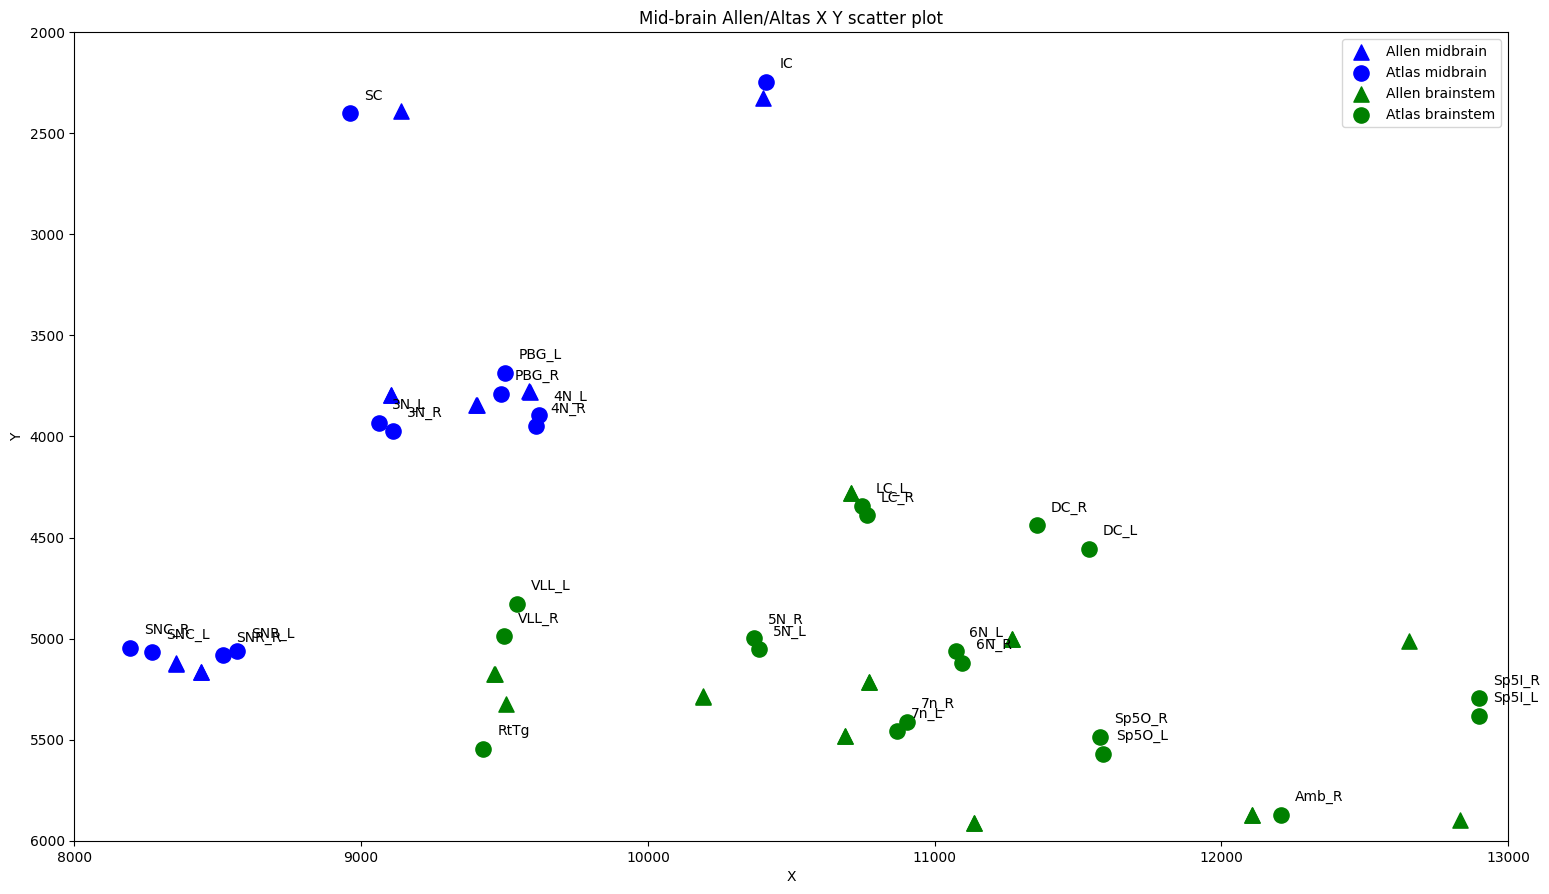

In [7]:
for color, label in zip('bg', ['midbrain', 'brainstem']):
    allen_subset = df_midbrain_allen[df_midbrain_allen.area == label]
    atlas_subset = df_midbrain_atlas[df_midbrain_atlas.area == label]
    plt.scatter(allen_subset.X, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Y')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
    #ax.annotate('x', (atlas_subset.X, atlas_subset.Y))
    #ax.annotate('x', xy=(atlas_subset.X, atlas_subset.Y))
plt.title('Mid-brain Allen/Altas X Y scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
for k, v in df_midbrain_atlas.iterrows():
    ax.annotate(v['Structure'],
                xy=(v['X'], v['Y']),
                xytext=(10, 10), textcoords='offset points',
                family='sans-serif', fontsize=10, color='black')

In [ ]:
for color, label in zip('bgr', ['midbrain', 'brainstem']):
    allen_subset = df_midbrain_allen[df_midbrain_allen.area == label]
    atlas_subset = df_midbrain_atlas[df_midbrain_atlas.area == label]
    plt.scatter(allen_subset.X, allen_subset.Z, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Z, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Z')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    #ax.invert_yaxis()
plt.title('Mid-brain Allen/Altas X Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
for color, label in zip('bgr', ['midbrain', 'brainstem']):
    allen_subset = df_midbrain_allen[df_midbrain_allen.area == label]
    atlas_subset = df_midbrain_atlas[df_midbrain_atlas.area == label]
    plt.scatter(allen_subset.Z, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.Z, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('Z')
    plt.ylabel('Y')
    ax = plt.gca()
    #ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('Midbrain Allen/Altas Y Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
for color, label in zip('bgr', ['midbrain', 'brainstem']):
    allen_subset = df_all_allen[df_all_allen.area == label]
    atlas_subset = df_all_atlas[df_all_atlas.area == label]
    plt.scatter(allen_subset.X, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Y')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('All structures - Allen/Altas X Y scatter plot')    
plt.legend()
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
for color, label in zip('bgr', ['midbrain', 'brainstem']):
    allen_subset = df_all_allen[df_all_allen.area == label]
    atlas_subset = df_all_atlas[df_all_atlas.area == label]
    plt.scatter(allen_subset.X, allen_subset.Z, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Z, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Z')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    #ax.invert_yaxis()
plt.title('All structures - Allen/Altas X Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
for color, label in zip('bgr', ['midbrain', 'brainstem']):
    allen_subset = df_all_allen[df_all_allen.area == label]
    atlas_subset = df_all_atlas[df_all_atlas.area == label]
    plt.scatter(allen_subset.Z, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.Z, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('Z')
    plt.ylabel('Y')
    ax = plt.gca()
    #ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('All structures - Allen/Altas Y Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
# xy
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_brainstem_allen[df_brainstem_allen.S == label]
    atlas_subset = df_brainstem_atlas[df_brainstem_atlas.S == label]
    plt.scatter(allen_subset.X, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Y')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('Brainstem Allen/Altas X Y scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
# xz
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_brainstem_allen[df_brainstem_allen.S == label]
    atlas_subset = df_brainstem_atlas[df_brainstem_atlas.S == label]
    plt.scatter(allen_subset.X, allen_subset.Z, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Z, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Z')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    #ax.invert_yaxis()
plt.title('Brainstem Allen/Altas X Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
# yz
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_brainstem_allen[df_brainstem_allen.S == label]
    atlas_subset = df_brainstem_atlas[df_brainstem_atlas.S == label]
    plt.scatter(allen_subset.Z, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.Z, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('Z')
    plt.ylabel('Y')
    ax = plt.gca()
    #ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('Brainstem Allen/Altas Y Z scatter plot')    
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)